In [ ]:
import json
import os
import random
import sys
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import trimesh

from utils.keypoints import project_3D_points_to_2D

parent_dir = os.path.abspath('../../')
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

from training.keypointnet import KeypointNet
from utils.heatmap import decode_heatmaps
from utils.image_handling import crop_image, pad_bbox
from utils.keypoints import crop_and_resize_keypoints

In [89]:
BASE_PATH = Path("../../")

In [ ]:

def load_sample(sample_path):
    with open(sample_path, 'r') as f:
        samples = json.load(f)
    return samples

def load_keypoints(keypoints_path):
    with open(keypoints_path, 'r') as f:
        data = json.load(f)
    keypoints = np.array(data['keypoints_3D'])
    return keypoints

def load_model(model_path):
    mesh = trimesh.load(model_path)
    return mesh

def load_size(size_path, obj_id):
    with open(size_path, 'r') as f:
        data = json.load(f)
        return data[obj_id]

In [91]:
def preprocess_image(image_path, bbox, target_size=(128, 128)):
    img = cv2.imread(str(image_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cropped_img = crop_image(img, bbox)
    resized_img = cv2.resize(cropped_img, target_size, interpolation=cv2.INTER_LINEAR)
    crop_tensor = torch.from_numpy(resized_img.astype(np.float32) / 255.0).permute(2, 0, 1).unsqueeze(0)
    return crop_tensor

In [92]:
def draw_model_overlay(img, projected_pts, faces=None, color=(0, 255, 0)):
    img_overlay = img.copy()
    
    if faces is not None:
        # Draw mesh faces
        for face in faces:
            pts = projected_pts[face].astype(np.int32)
            cv2.polylines(img_overlay, [pts], isClosed=True, color=color, thickness=1)
    else:
        # Draw points only
        for (x, y) in projected_pts.astype(np.int32):
            cv2.circle(img_overlay, (x, y), 2, color, -1)

    return img_overlay

In [ ]:

def draw_pose(img, model_path, R, t, K):
    mesh = load_model(model_path)

    # Optional: scale vertices if model was in millimeters
    vertices = mesh.vertices.copy()
    if vertices.max() > 10:  # crude check if it's not already in meters
        vertices *= 0.001  # convert mm → meters

    faces = mesh.faces if hasattr(mesh, 'faces') else None

    projected_pts = project_3D_points_to_2D(vertices, R, t, K)
    overlay = draw_model_overlay(img, projected_pts, faces=faces)
    return overlay

In [ ]:
def get_3d_bounding_box_from_min_size(min_xyz, size_xyz):
    """
    Create 8 corner points from min corner and size.
    min_xyz: [min_x, min_y, min_z] in meters
    size_xyz: [size_x, size_y, size_z] in meters
    """
    min_x, min_y, min_z = min_xyz
    size_x, size_y, size_z = size_xyz

    # Define corners relative to min point
    corners = np.array([
        [min_x, min_y, min_z],
        [min_x + size_x, min_y, min_z],
        [min_x + size_x, min_y + size_y, min_z],
        [min_x, min_y + size_y, min_z],
        [min_x, min_y, min_z + size_z],
        [min_x + size_x, min_y, min_z + size_z],
        [min_x + size_x, min_y + size_y, min_z + size_z],
        [min_x, min_y + size_y, min_z + size_z]
    ])
    return corners  # (8, 3)

def draw_3d_bbox(img, corners_2D, color=(0, 255, 0)):
    corners_2D = corners_2D.astype(int)

    # Define the 12 bounding box lines
    connections = [
        (0, 1), (1, 2), (2, 3), (3, 0),  # bottom rectangle
        (4, 5), (5, 6), (6, 7), (7, 4),  # top rectangle
        (0, 4), (1, 5), (2, 6), (3, 7)   # vertical lines
    ]

    img_box = img.copy()
    for start, end in connections:
        pt1 = tuple(corners_2D[start])
        pt2 = tuple(corners_2D[end])
        cv2.line(img_box, pt1, pt2, color, 2)

    return img_box

def draw_bounding_box(img, size_dict, R, t, K):
    """
    size_dict: a dict containing min_x, min_y, min_z, size_x, size_y, size_z in mm
    """
    # Convert from mm → meters
    min_xyz_m = np.array([size_dict['min_x'], size_dict['min_y'], size_dict['min_z']]) * 0.001
    size_xyz_m = np.array([size_dict['size_x'], size_dict['size_y'], size_dict['size_z']]) * 0.001

    bbox_3D = get_3d_bounding_box_from_min_size(min_xyz_m, size_xyz_m)  # (8, 3)
    bbox_2D = project_3D_points_to_2D(bbox_3D, R, t, K)  # (8, 2)
    img_with_bbox = draw_3d_bbox(img, bbox_2D)
    return img_with_bbox


In [94]:
def draw_axes(img, K, R, t, center_2D, axis_length=0.1):
    """
    img: background image (BGR)
    K: camera intrinsics (3,3)
    R: rotation matrix (3,3)
    t: translation vector (3,)
    center_2D: 2D pixel location (x, y) to anchor the axes
    axis_length: how long each axis is in meters
    """
    # Define axis endpoints in 3D object frame
    axis_3D = np.array([
        [0, 0, 0],              # origin
        [axis_length, 0, 0],    # X axis
        [0, axis_length, 0],    # Y axis
        [0, 0, axis_length]     # Z axis
    ])

    # Transform axes into camera frame
    axis_cam = (R @ axis_3D.T).T + t.reshape(1, 3)

    # Project to 2D
    points_proj = (K @ axis_cam.T).T
    points_proj = points_proj[:, :2] / points_proj[:, 2:3]  # (N, 2)

    # Shift so origin matches detected centroid (center_2D)
    offset = center_2D - points_proj[0]
    points_proj += offset

    # Draw lines
    img_axes = img.copy()
    origin = tuple(points_proj[0].astype(int))
    x_end = tuple(points_proj[1].astype(int))
    y_end = tuple(points_proj[2].astype(int))
    z_end = tuple(points_proj[3].astype(int))

    cv2.line(img_axes, origin, x_end, (0, 0, 255), 2)   # X axis in RED
    cv2.line(img_axes, origin, y_end, (0, 255, 0), 2)   # Y axis in GREEN
    cv2.line(img_axes, origin, z_end, (255, 0, 0), 2)   # Z axis in BLUE

    return img_axes


In [ ]:
from utils.evaluation import compute_pck, estimate_pose_pnp_ransac
from utils.keypoints import map_keypoints_to_original


def visualize_model_quality(obj_id, samples):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    NUM_KEYPOINTS = 15
    IMAGE_SIZE =(128, 128)
    keypoints_path = BASE_PATH / f"data/keypoints3d/{obj_id:06d}.json"
    MODEL_PATH = BASE_PATH / f"models/r6dnet/obj_{obj_id:06d}.pt"
    keypoints_3d = load_keypoints(keypoints_path)
    
    model = KeypointNet(
        num_keypoints=NUM_KEYPOINTS,
        output_size=IMAGE_SIZE,
    ).to(device)

    model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
    model.eval()

    # fig, axes = plt.subplots(2, len(samples), figsize=(5 * len(samples), 10))

    if len(samples) == 1:
        axes = [axes]

    for i, sample_entry in enumerate(samples):
        image_id = sample_entry['image_id']
        bbox =  pad_bbox(sample_entry['bbox_obj'])
        keypoints = np.array(sample_entry['keypoints_2D'])
        image_path = BASE_PATH / sample_entry['rgb_path']
        K = np.array(sample_entry['K'])
        R = np.array(sample_entry['rotation']).reshape(3, 3)
        t = np.array(sample_entry['translation']).reshape(3, 1)
        gt_keypoints = crop_and_resize_keypoints(keypoints, bbox, IMAGE_SIZE)
        # gt_heatmaps = generate_multi_gaussian_heatmaps(gt_keypoints, *IMAGE_SIZE, sigma=5)
        img = preprocess_image(image_path, bbox).to(device)

        with torch.no_grad():
            heatmaps = model(img)
            heatmaps_np = heatmaps.cpu().numpy()[0]
            decoded_keypoints = decode_heatmaps(heatmaps_np)
            pred_keypoints_orig = map_keypoints_to_original(decoded_keypoints, bbox, IMAGE_SIZE)
            pred_keypoints_orig = np.array(pred_keypoints_orig)
            # print(pred_keypoints_orig)
            # print(keypoints)
            
            # pck = compute_pck(pred_keypoints_orig, gt_keypoints_2D, threshold=5.0)
            
        try:
            rvec, tvec = estimate_pose_pnp_ransac(keypoints_3d, pred_keypoints_orig, K)
            R_pred, _ = cv2.Rodrigues(rvec)
        except RuntimeError:
            continue
        # print(R_pred)
        # print(tvec)
            
        # axes[0][i].imshow(img.cpu().numpy()[0].transpose(1, 2, 0))
        # axes[0][i].scatter(gt_keypoints[:, 0], gt_keypoints[:, 1], c='red', label='GT', s=50, marker='x')
        # axes[0][i].scatter(decoded_keypoints[:, 0], decoded_keypoints[:, 1], c='blue', label='GT', s=50, marker='+')
        # axes[0][i].set_title(f"Sample {image_id}")
        # axes[0][i].axis('off')

        # axes[1][i].imshow(heatmaps_np.sum(axis=0), cmap='jet')
        # axes[1][i].scatter(decoded_keypoints[:, 0], decoded_keypoints[:, 1], c='red', label='Decoded', s=30, marker='o')
        # axes[1][i].axis('off')

        raw_img = cv2.imread(str(image_path))
        raw_img = cv2.cvtColor(raw_img, cv2.COLOR_BGR2RGB)

        size_dict = load_size(BASE_PATH / "datasets/lms/models/models_info.json", obj_id)

        # img_with_axes = draw_axes(raw_img, K, R_pred, tvec, pred_keypoints_orig[0])
        img_with_bbox = draw_bounding_box(img, size_dict, R_pred, tvec, K)
        plt.imshow(img_with_bbox)
        # axes[1][i].scatter(keypoints[:, 0], keypoints[:, 1], c='red', label='GT', s=50, marker='x')
        # axes[1][i].scatter(pred_keypoints_orig[:, 0], pred_keypoints_orig[:, 1], c='red', label='Decoded', s=30, marker='o')
        # axes[2, i].axis('off')
        plt.tight_layout()
        plt.show()



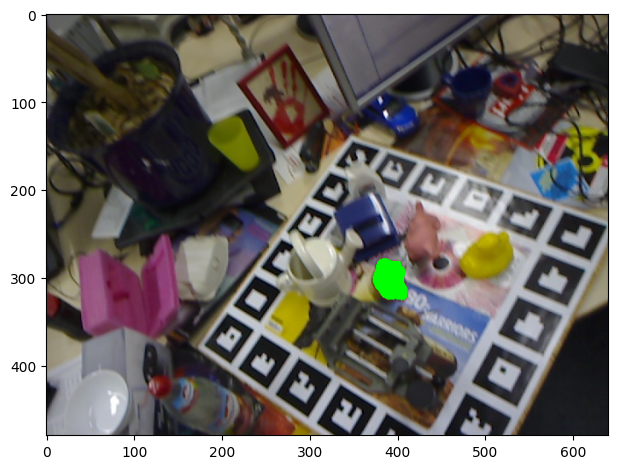

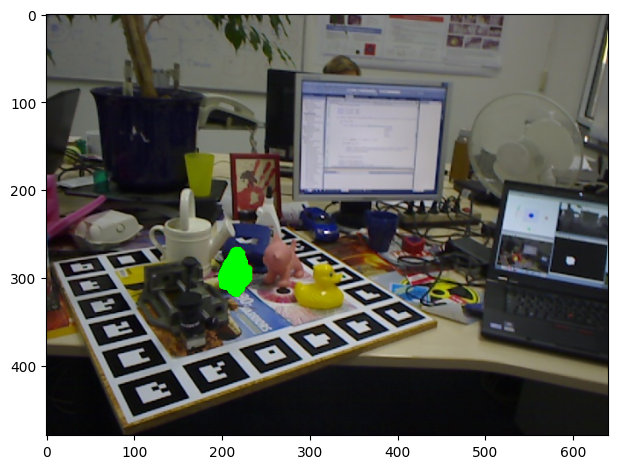

In [100]:
obj_id = 1  # Change as needed
sample_path = BASE_PATH / f"data/annotations/test/{obj_id:06d}.json"
samples = load_sample(sample_path)

# Randomly select 3 samples
random.seed(42)
selected_samples = random.sample(samples, 2)
visualize_model_quality(obj_id, selected_samples)